In [1]:
# %matplotlib widget
%load_ext autoreload
%autoreload 2

## Imports

In [2]:
# modified from test.ipynb and main.py

import time
import os
import joblib
from utils import plot_3d_boundary, plot_3d_observed_rewards
from pylab import *
from matplotlib import pyplot as plt
from matplotlib import cm
import numpy as np
import GPy

import warnings
warnings.filterwarnings('ignore')

import logging
logging.basicConfig(level=logging.INFO)

from emukit.model_wrappers import GPyModelWrapper
from emukit.model_wrappers.gpy_quadrature_wrappers import BaseGaussianProcessGPy, RBFGPy

from emukit.core import ParameterSpace, ContinuousParameter, DiscreteParameter
from emukit.core.loop import UserFunctionWrapper

from emukit.core import ParameterSpace, ContinuousParameter
from emukit.core.initial_designs import RandomDesign

from GPy.models import GPRegression

from skopt.benchmarks import branin as _branin
from emukit.test_functions import branin_function

from scse.api.simulation import run_simulation

from matplotlib.colors import LogNorm
from matplotlib import pyplot as plt

# Decision loops 
from emukit.experimental_design import ExperimentalDesignLoop
from emukit.bayesian_optimization.loops import BayesianOptimizationLoop
from emukit.quadrature.loop import VanillaBayesianQuadratureLoop

# Acquisition functions 
from emukit.bayesian_optimization.acquisitions import ExpectedImprovement
from emukit.experimental_design.acquisitions import ModelVariance
# from emukit.quadrature.acquisitions import IntegralVarianceReduction
from emukit.experimental_design.acquisitions import IntegratedVarianceReduction

# Acquistion optimizers
from emukit.core.optimization import GradientAcquisitionOptimizer

# Stopping conditions
from emukit.core.loop import FixedIterationsStoppingCondition
from emukit.core.loop import ConvergenceStoppingCondition

from emukit.bayesian_optimization.acquisitions.log_acquisition import LogAcquisition

# Constraints
from emukit.core.constraints import LinearInequalityConstraint



warning in stationary: failed to import cython module: falling back to numpy
warning in coregionalize: failed to import cython module: falling back to numpy
warning in choleskies: failed to import cython module: falling back to numpy


In [3]:
# Libraries for multiprocessing
from multiprocess.pool import Pool
from tqdm.auto import tqdm

In [4]:
from loop import *

## miniSCOT Functions

In [73]:
scenario

'Baseline (20 % Discount)'

In [59]:
surge_modulator = 1.0
all_scenarios = {"Baseline (20 % Discount)": {"discharge_discount": 0.8,
                                              "charging_discount": 1.05,
                                              "surge_modulator": surge_modulator},
                 "25 % Discount": {"discharge_discount": 0.75,
                                    "charging_discount": 1.05,
                                    "surge_modulator": surge_modulator},
                 "33 % Discount": {"discharge_discount": 0.67,
                                   "charging_discount": 1.05,
                                   "surge_modulator": surge_modulator},
                 "33 % Discount +": {"discharge_discount": 0.67,
                                     "charging_discount": 1.0,
                                     "surge_modulator": surge_modulator},
                 "50 % Discount": {"discharge_discount": 0.5,
                                   "charging_discount": 1.05,
                                   "surge_modulator": surge_modulator}}

# Specify scenario here
possible_scenarios = list(all_scenarios.keys())


In [21]:
def invoke_miniscot(x):
    """
    Handling single API call to miniSCOT simulation given some inputs

    x contains parameter configs x = [x0 x1 ...]
    - The order of parameters in x should follow the order specified in the parameter_space declaration
    - E.g. here we specify num_batteries = x[0]
    """

    kwargs = {
        'time_horizon': 336*1,
        'num_batteries': int(x[0])
    }

    kwargs.update(all_scenarios[scenario])

    if len(x) == 2:
        kwargs.update({
            'max_battery_capacity': int(x[1])
        })

    elif len(x) == 3:
        kwargs.update({
            'max_battery_capacity': int(x[1]),
            # 'time_horizon': int(x[2])
            'battery_penalty': int(x[2])
        })
    elif len(x) == 4:
        kwargs.update({
            'max_battery_capacity': int(x[1]),
            'time_horizon': int(x[2]),
            'battery_penalty': int(x[3])
        })

    cum_reward = run_simulation(**kwargs)
    
    return cum_reward[-1]
    

In [7]:
def f(X):
    """
    Handling multiple API calls to miniSCOT simulation given some inputs

    X is a matrix of parameters
    - Each row is a set of parameters
    - The order of parameters in the row should follow the order specified in the parameter_space declaration
    """
    Y = []
    for x in X:
        cum_reward = invoke_miniscot(x)

        # Note that we negate the reward; want to find min
        Y.append(-cum_reward[-1])

    Y = np.reshape(np.array(Y), (-1, 1))
    return Y

In [8]:
def f_multiprocess(X):
    """
    Handling multiple API calls to miniSCOT simulation given some inputs using multiprocessing.

    X is a matrix of parameters
    - Each row is a set of parameters
    - The order of parameters in the row should follow the order specified in the parameter_space declaration
    """
    
    # Set to None to use all available CPU
    max_pool = None
    with Pool(max_pool) as p:
        Y = list(
            tqdm(
                p.imap(invoke_miniscot, X),
                total=X.shape[0]
            )
        )

    # Note that we negate the reward; want to find min
    Y = -np.reshape(np.array(Y), (-1, 1))
    return Y

## Plotting Functions

In [8]:
def plot_reward(X, Y, labels):
    """
    Plots reward against a maximum of two dimensions.
    """

    plt.style.use('seaborn')
    fig = plt.figure(figsize=(12, 12))

    order = np.argsort(X[:,0])
    
    if X.shape[1] == 1:
        ax = plt.axes()
        ax.plot(X[order,0], Y[order])
        ax.set_xlabel(labels[0])
        ax.set_ylabel("Cumulative reward")
    elif X.shape[1] == 2:
        ax = plt.axes(projection='3d')
        im = ax.plot_trisurf(X[order,0].flatten(), X[order,1].flatten(), Y[order].flatten(), cmap=cm.get_cmap('autumn'))
        fig.colorbar(im)
        ax.set_xlabel(labels[0])
        ax.set_ylabel(labels[1])
        ax.set_zlabel("Cumulative reward")  # (£/MWh)
    else:
        raise ValueError('X has too many dimensions to plot - max 2 allowed')

    return fig, ax

## Specify Parameter Space

In [9]:
from scse.default_run_parameters.national_grid_default_run_parameters import DEFAULT_RUN_PARAMETERS

Here we define the parameter space. If you want to look at a complete experiment, just go to Time Horizon header

You can add/remove parameters in `parameters` list. If you leave out the time_horizon column (not recommended), you will need to update the GP kernel specification `input_dim` accordingly (currently subtracts 1 for that column)

The SA code attempted to evaluate performance under different battery penalties. There are no plotting capabilities supporting this 4D `X` array yet.

In [50]:
max_num_batteries = 1000
min_battery_capacity = 0
max_battery_capacity = 100

# Unsure if these are appropriate, so don't take this as truth
min_battery_penalty = DEFAULT_RUN_PARAMETERS.battery_penalty - 10
max_battery_penalty = DEFAULT_RUN_PARAMETERS.battery_penalty + 10

num_data_points = 30

timesteps_per_week = 336
num_weeks = 52
time_horizon_value = timesteps_per_week*1

num_batteries = DiscreteParameter('num_batteries', range(0, max_num_batteries+1))
max_battery_capacities = DiscreteParameter('max_battery_capacity', range(min_battery_capacity, max_battery_capacity+1))
battery_penalty = DiscreteParameter(
    'battery_penalty', range(min_battery_penalty, max_battery_penalty+1))

# Specify time horizon here changing time_horizon_value above
time_horizon = DiscreteParameter('time_horizon', [time_horizon_value])

parameters = [num_batteries, max_battery_capacities, time_horizon] # , battery_penalty]
# parameters = [num_batteries, max_battery_capacities]
parameter_space = ParameterSpace(parameters)

In [72]:
scenario_num = 0
scenario = possible_scenarios[scenario_num]

## Sensitivity Analsyis Playground (WIP)

In [ ]:
design = RandomDesign(parameter_space)

# Get initial data points
print(20* '=' + " using scenario [{}] ".format(scenario) + 20*'=')
X = design.get_samples(num_data_points)
start = time.time()
Y = f_multiprocess(X)
end = time.time()
print("Getting {} initial simulation points took {} seconds".format(
    num_data_points, round(end - start, 0)))

- Specify the feature columns you want to fit the GP on via active_dims
- I believe that the input_dim needs to be equal to the number of specified active dims (not sure tho, might need to double check for yourself)
    - => just think about the X you are feeding to the GP and which columns need to be ignored / or fitted on. 

In [ ]:
# Kernel Specification; specify active dimensions
# kr = GPy.kern.RBF(input_dim=X.shape[1]-1, active_dims=[0, 1, 2], ARD=True)  # exclude time dim
# kb = GPy.kern.Bias(input_dim=X.shape[1]-1, active_dims=[0, 1, 2])

kr = GPy.kern.RBF(input_dim=X.shape[1], active_dims=[0, 1], ARD=True)
kb = GPy.kern.Bias(input_dim=X.shape[1], active_dims=[0, 1])

kernel = kr+kb

# Some prior distributions for model parameters
v_prior = GPy.priors.Gamma.from_EV(1000, 100.)
l_prior = GPy.priors.Gamma.from_EV(100, 1000.)

# Some prior distributions for model parameters
gpy_model = GPy.models.GPRegression(X, Y, kernel, noise_var=1e-10)
gpy_model.kern.rbf.variance.set_prior(v_prior)
gpy_model.kern.rbf.lengthscale.set_prior(l_prior)
gpy_model.Gaussian_noise.variance.constrain_fixed()

# gpy_model.optimize()
gpy_model.optimize_restarts(
    num_restarts=10, robust=False, verbose=False, messages=False)

# Logging GP fit
_ = gpy_model.plot(visible_dims=[0,1])
display(gpy_model)
print(gpy_model.kern.rbf.lengthscale)

model_emukit = GPyModelWrapper(gpy_model)

run_bo = True
if run_bo:
    # ======== Run BO to acquire points but also fit GP =========

    # Choose acquisition function
    ei_acq = ExpectedImprovement(model_emukit)
    acq_func = ei_acq

    # Load core elements for Bayesian optimization
    optimizer = GradientAcquisitionOptimizer(space=parameter_space)

    # Create the Bayesian optimization object
    batch_size = 5
    bayesopt_loop = BayesianOptimizationLoop(model=model_emukit,
                                            space=parameter_space,
                                            acquisition=acq_func,
                                            batch_size=batch_size)

    # Run the loop and extract the optimum;  we either complete 10 steps or converge
    max_iters = 10
    epsilon = 0.00001
    stopping_condition = (FixedIterationsStoppingCondition(
        i_max=max_iters) | ConvergenceStoppingCondition(eps=epsilon))

    print(20 * '=' + " using scenario [{}] ".format(scenario) + 20*'=')
    start = time.time()
    bayesopt_loop.run_loop(f_multiprocess, stopping_condition)
    end = time.time()
    print("Successfully ran loop")

    # Get acquired data
    new_X, new_Y = bayesopt_loop.loop_state.X, bayesopt_loop.loop_state.Y
    new_order = np.argsort(new_X[:, 0])
    new_X = new_X[new_order, :]
    new_Y = new_Y[new_order]
    total_num_points = new_Y.shape[0]
    num_eval_points = total_num_points-num_data_points
    print("Getting {} simulation points (batch size {}) took {} seconds".format(
        num_eval_points, batch_size, round(end - start, 0)))

    results = bayesopt_loop.get_results()
    print("minimum X: ", end='')
    print(results.minimum_location)
    print("minimum Y: ", end='')
    print(round(results.minimum_value, 0))

    # This assumes that first two columns of X were num_battery & max_battery_capacity
    best_total_inserted_capacity = results.minimum_location[0] * \
        results.minimum_location[1]
    print("optimal total inserted capacity: {}".format(
        best_total_inserted_capacity))

    print("Number of (new) points evaluated: {} (batch size {})".format(
        num_eval_points, batch_size))

    # Plot 3D decision boundary
    mesh_X, mesh_Y = np.mgrid[1:max_num_batteries+1:1,
                              min_battery_capacity:max_battery_capacity+1:1]
    positions = np.vstack([mesh_X.ravel(), mesh_Y.ravel()]).T
    positions_with_time = np.append(positions, np.reshape(
        np.array([time_horizon_value for _ in range(positions.shape[0])]), (-1, 1)), axis=1)

    mu_plot, var_plot = model_emukit.predict(positions_with_time)
    kwargs = {
        'X': X,
        'Y': Y,
        'plot_new': True,
        'new_X': new_X,
        'new_Y': new_Y,
        'mesh_X': mesh_X,
        'mesh_Y': mesh_Y,
        'mu_plot': mu_plot,
        'var_plot': var_plot,
        'plot_ci': False,
        'elev': 10,
        'angle': 120
    }
    fig, ax = plot_3d_boundary(**kwargs)

    kwargs = {
        'X': X,
        'Y': Y,
        'new_X': new_X,
        'new_Y': new_Y,
        'elev': 10,
        'angle': 120
        # 'save_fig_path': "img/time_horizon/{}/{}_obs".format(num_days, num_days)
    }
    fig, ax = plot_3d_observed_rewards(**kwargs)

In [36]:
results.minimum_location

array([44., 19.])

In [37]:
results.minimum_value

546290.7837313554

In [39]:
best_total_inserted_capacity

836.0

In [20]:
from emukit.sensitivity.monte_carlo import MonteCarloSensitivity, ModelFreeMonteCarloSensitivity

# Use emulator model
sens_sim = ModelFreeMonteCarloSensitivity(f_multiprocess, parameter_space)
sens_emu = MonteCarloSensitivity(model_emukit, parameter_space)

Since running Monte Carlo on the simulator is prohibitively expensive, we evaluate the MC effects on the emulator. 

(I just might run the MC on simulator overnight to compare the accuracy of results)

In [21]:
num_mc = 100000
main_effects, total_effects, _ = sens_emu.compute_effects(
    num_monte_carlo_points=num_mc)
main_effects


{'num_batteries': array([0.99582169]),
 'max_battery_capacity': array([0.006876]),
 'time_horizon': array([0.00620942]),
 'battery_penalty': array([0.00620942])}

In [22]:
total_effects


{'num_batteries': array([0.99458171]),
 'max_battery_capacity': array([-0.01918408]),
 'time_horizon': array([-0.02094839]),
 'battery_penalty': array([-0.02094839])}

In [73]:
# # playground code to generate 3D grid
# m_X, m_Y, m_Z = np.mgrid[1:max_num_batteries+1:1, min_battery_capacity:
#                          max_battery_capacity+1:1, min_battery_penalty:max_battery_penalty+1:1]

# positions = np.vstack([m_X.ravel(), m_Y.ravel(), m_Z.ravel()]).T
# positions_with_time = np.append(positions, np.reshape(
#     np.array([time_horizon_value for _ in range(positions.shape[0])]), (-1, 1)), axis=1)

# mu_plot, var_plot = model_emukit.predict(positions_with_time)

Plotting some GP  fit

In [ ]:
# # Get acquired data
# new_X, new_Y = bayesopt_loop.loop_state.X, bayesopt_loop.loop_state.Y
# new_order = np.argsort(new_X[:, 0])
# new_X = new_X[new_order, :]
# new_Y = new_Y[new_order]
# total_num_points = new_Y.shape[0]
# num_eval_points = total_num_points-num_data_points
# print("Getting {} simulation points (batch size {}) took {} seconds".format(
#     num_eval_points, batch_size, round(end - start, 0)))

# results = bayesopt_loop.get_results()
# print("minimum X: ", end='')
# print(results.minimum_location)
# print("minimum Y: ", end='')
# print(round(results.minimum_value, 0))

# print("Number of (new) points evaluated: {} (batch size {})".format(
#     num_eval_points, batch_size))

# Plot 3D decision boundary
mesh_X, mesh_Y = np.mgrid[1:max_num_batteries+1:1,
                          min_battery_capacity:max_battery_capacity+1:1]
positions = np.vstack([mesh_X.ravel(), mesh_Y.ravel()]).T
positions_with_time = np.append(positions, np.reshape(
    np.array([time_horizon_value for _ in range(positions.shape[0])]), (-1, 1)), axis=1)

mu_plot, var_plot = model_emukit.predict(positions_with_time)
kwargs = {
    'X': X,
    'Y': Y,
    # 'plot_new': True,
    # 'new_X': new_X,
    # 'new_Y': new_Y,
    'mesh_X': mesh_X,
    'mesh_Y': mesh_Y,
    'mu_plot': mu_plot,
    'var_plot': var_plot,
    'title': "GP fit post BO loop",
    'plot_ci': False,
    'elev': 10,
    'angle': 120
    # 'save_fig_path': "img/time_horizon/{}/{}_sim".format(num_days, num_days),
}
fig, ax = plot_3d_boundary(**kwargs)

kwargs = {
    'X': X,
    'Y': Y,
    'plot_new': False,
    # 'new_X': new_X,
    # 'new_Y': new_Y,
    'elev': 10,
    'angle': -120,
    'title': "Observed rewards"
    # 'save_fig_path': "img/time_horizon/{}/{}_obs".format(num_days, num_days)
}
fig, ax = plot_3d_observed_rewards(**kwargs)


## Time Horizon

This experiment feeds X = [`num_batteries`, `battery_capacity`, `time_horizon`] to the GP and the GP fits on the first two. 

We vary the time horizon to evaluate the best configuration & reward across different time horizons.

No specification of any (battery) penalties here, so that's all using base scenario parameters.

Some of the parameter space was prespecified & run above, so keep that in mind if you run this cold

==================== using scenario [Baseline (20 % Discount)] ====================
CURRENT ATTEMPT #0

==================== Simulating with time horizon of 1 days ====================


100%|██████████| 10/10 [00:35<00:00,  3.56s/it]
INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


Getting 10 initial simulation points took 36.0 seconds


GP_regression.,value,constraints,priors
sum.rbf.variance,160776.45684162911,+ve,"Ga(1e+04, 10)"
sum.rbf.lengthscale,"(2,)",+ve,"Ga(10, 0.1)"
sum.bias.variance,122010.58725520651,+ve,
Gaussian_noise.variance,1e-10,+ve fixed,


  index  |  GP_regression.sum.rbf.lengthscale  |  constraints  |    priors   
  [0]    |                       117.68554358  |      +ve      |  Ga(10, 0.1)
  [1]    |                        13.04376289  |      +ve      |  Ga(10, 0.1)


INFO:emukit.bayesian_optimization.loops.bayesian_optimization_loop:Batch size is 5, using LocalPenalizationPointCalculator
INFO:emukit.core.loop.outer_loop:Starting outer loop
INFO:emukit.core.loop.outer_loop:Iteration 0
INFO:emukit.core.loop.model_updaters:Updating parameters of the model
INFO:emukit.core.optimization.gradient_acquisition_optimizer:Starting gradient-based optimization of acquisition function <class 'emukit.core.acquisition.acquisition.Sum'>
INFO:emukit.core.optimization.gradient_acquisition_optimizer:Starting gradient-based optimization of acquisition function <class 'emukit.core.acquisition.acquisition.Sum'>
INFO:emukit.core.optimization.gradient_acquisition_optimizer:Starting gradient-based optimization of acquisition function <class 'emukit.core.acquisition.acquisition.Sum'>
INFO:emukit.core.optimization.gradient_acquisition_optimizer:Starting gradient-based optimization of acquisition function <class 'emukit.core.acquisition.acquisition.Sum'>
INFO:emukit.core.opti

Successfully ran loop
Getting 15 simulation points (batch size 5) took 77.0 seconds
minimum X: [640.  66.  48.]
minimum Y: -295759.0
optimal total inserted capacity: 42240.0
Number of (new) points evaluated: 15 (batch size 5)
CURRENT ATTEMPT #0

==================== Simulating with time horizon of 10 days ====================


100%|██████████| 10/10 [00:32<00:00,  3.21s/it]
INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


Getting 10 initial simulation points took 32.0 seconds


GP_regression.,value,constraints,priors
sum.rbf.variance,116111.75643390931,+ve,"Ga(1e+04, 10)"
sum.rbf.lengthscale,"(2,)",+ve,"Ga(10, 0.1)"
sum.bias.variance,115625271.76739363,+ve,
Gaussian_noise.variance,1e-10,+ve fixed,


  index  |  GP_regression.sum.rbf.lengthscale  |  constraints  |    priors   
  [0]    |                        38.08451289  |      +ve      |  Ga(10, 0.1)
  [1]    |                      1800.26478333  |      +ve      |  Ga(10, 0.1)


INFO:emukit.bayesian_optimization.loops.bayesian_optimization_loop:Batch size is 5, using LocalPenalizationPointCalculator
INFO:emukit.core.loop.outer_loop:Starting outer loop
INFO:emukit.core.loop.outer_loop:Iteration 0
INFO:emukit.core.loop.model_updaters:Updating parameters of the model
INFO:emukit.core.optimization.gradient_acquisition_optimizer:Starting gradient-based optimization of acquisition function <class 'emukit.core.acquisition.acquisition.Sum'>
INFO:emukit.core.optimization.gradient_acquisition_optimizer:Starting gradient-based optimization of acquisition function <class 'emukit.core.acquisition.acquisition.Sum'>
INFO:emukit.core.optimization.gradient_acquisition_optimizer:Starting gradient-based optimization of acquisition function <class 'emukit.core.acquisition.acquisition.Sum'>
INFO:emukit.core.optimization.gradient_acquisition_optimizer:Starting gradient-based optimization of acquisition function <class 'emukit.core.acquisition.acquisition.Sum'>
INFO:emukit.core.opti

Successfully ran loop
Getting 10 simulation points (batch size 5) took 51.0 seconds
minimum X: [577.  68. 480.]
minimum Y: -317182.0
optimal total inserted capacity: 39236.0
Number of (new) points evaluated: 10 (batch size 5)
CURRENT ATTEMPT #0

==================== Simulating with time horizon of 30 days ====================


100%|██████████| 10/10 [00:30<00:00,  3.06s/it]
INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


Getting 10 initial simulation points took 31.0 seconds


GP_regression.,value,constraints,priors
sum.rbf.variance,120989.85816848188,+ve,"Ga(1e+04, 10)"
sum.rbf.lengthscale,"(2,)",+ve,"Ga(10, 0.1)"
sum.bias.variance,339623.71906554856,+ve,
Gaussian_noise.variance,1e-10,+ve fixed,


  index  |  GP_regression.sum.rbf.lengthscale  |  constraints  |    priors   
  [0]    |                        90.58703722  |      +ve      |  Ga(10, 0.1)
  [1]    |                        20.72411932  |      +ve      |  Ga(10, 0.1)


INFO:emukit.bayesian_optimization.loops.bayesian_optimization_loop:Batch size is 5, using LocalPenalizationPointCalculator
INFO:emukit.core.loop.outer_loop:Starting outer loop
INFO:emukit.core.loop.outer_loop:Iteration 0
INFO:emukit.core.loop.model_updaters:Updating parameters of the model
INFO:emukit.core.optimization.gradient_acquisition_optimizer:Starting gradient-based optimization of acquisition function <class 'emukit.core.acquisition.acquisition.Sum'>
INFO:emukit.core.optimization.gradient_acquisition_optimizer:Starting gradient-based optimization of acquisition function <class 'emukit.core.acquisition.acquisition.Sum'>
INFO:emukit.core.optimization.gradient_acquisition_optimizer:Starting gradient-based optimization of acquisition function <class 'emukit.core.acquisition.acquisition.Sum'>
INFO:emukit.core.optimization.gradient_acquisition_optimizer:Starting gradient-based optimization of acquisition function <class 'emukit.core.acquisition.acquisition.Sum'>
INFO:emukit.core.opti

Successfully ran loop
Getting 10 simulation points (batch size 5) took 53.0 seconds
minimum X: [ 948.   72. 1440.]
minimum Y: -418467.0
optimal total inserted capacity: 68256.0
Number of (new) points evaluated: 10 (batch size 5)
CURRENT ATTEMPT #0

==================== Simulating with time horizon of 60 days ====================


100%|██████████| 10/10 [00:30<00:00,  3.04s/it]
INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


Getting 10 initial simulation points took 31.0 seconds


GP_regression.,value,constraints,priors
sum.rbf.variance,166585.5169646092,+ve,"Ga(1e+04, 10)"
sum.rbf.lengthscale,"(2,)",+ve,"Ga(10, 0.1)"
sum.bias.variance,75668728.76274347,+ve,
Gaussian_noise.variance,1e-10,+ve fixed,


  index  |  GP_regression.sum.rbf.lengthscale  |  constraints  |    priors   
  [0]    |                       248.65187218  |      +ve      |  Ga(10, 0.1)
  [1]    |                         5.04083251  |      +ve      |  Ga(10, 0.1)


INFO:emukit.bayesian_optimization.loops.bayesian_optimization_loop:Batch size is 5, using LocalPenalizationPointCalculator
INFO:emukit.core.loop.outer_loop:Starting outer loop
INFO:emukit.core.loop.outer_loop:Iteration 0
INFO:emukit.core.loop.model_updaters:Updating parameters of the model
INFO:emukit.core.optimization.gradient_acquisition_optimizer:Starting gradient-based optimization of acquisition function <class 'emukit.core.acquisition.acquisition.Sum'>
INFO:emukit.core.optimization.gradient_acquisition_optimizer:Starting gradient-based optimization of acquisition function <class 'emukit.core.acquisition.acquisition.Sum'>
INFO:emukit.core.optimization.gradient_acquisition_optimizer:Starting gradient-based optimization of acquisition function <class 'emukit.core.acquisition.acquisition.Sum'>
INFO:emukit.core.optimization.gradient_acquisition_optimizer:Starting gradient-based optimization of acquisition function <class 'emukit.core.acquisition.acquisition.Sum'>
INFO:emukit.core.opti

Successfully ran loop
Getting 10 simulation points (batch size 5) took 54.0 seconds
minimum X: [ 973.   81. 2880.]
minimum Y: -582516.0
optimal total inserted capacity: 78813.0
Number of (new) points evaluated: 10 (batch size 5)
CURRENT ATTEMPT #0

==================== Simulating with time horizon of 120 days ====================


100%|██████████| 10/10 [00:29<00:00,  2.95s/it]
INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


Getting 10 initial simulation points took 30.0 seconds


GP_regression.,value,constraints,priors
sum.rbf.variance,262297.1078517181,+ve,"Ga(1e+04, 10)"
sum.rbf.lengthscale,"(2,)",+ve,"Ga(10, 0.1)"
sum.bias.variance,159087718.8980348,+ve,
Gaussian_noise.variance,1e-10,+ve fixed,


  index  |  GP_regression.sum.rbf.lengthscale  |  constraints  |    priors   
  [0]    |                       187.69895492  |      +ve      |  Ga(10, 0.1)
  [1]    |                        30.89817733  |      +ve      |  Ga(10, 0.1)


INFO:emukit.bayesian_optimization.loops.bayesian_optimization_loop:Batch size is 5, using LocalPenalizationPointCalculator
INFO:emukit.core.loop.outer_loop:Starting outer loop
INFO:emukit.core.loop.outer_loop:Iteration 0
INFO:emukit.core.loop.model_updaters:Updating parameters of the model
INFO:emukit.core.optimization.gradient_acquisition_optimizer:Starting gradient-based optimization of acquisition function <class 'emukit.core.acquisition.acquisition.Sum'>
INFO:emukit.core.optimization.gradient_acquisition_optimizer:Starting gradient-based optimization of acquisition function <class 'emukit.core.acquisition.acquisition.Sum'>
INFO:emukit.core.optimization.gradient_acquisition_optimizer:Starting gradient-based optimization of acquisition function <class 'emukit.core.acquisition.acquisition.Sum'>
INFO:emukit.core.optimization.gradient_acquisition_optimizer:Starting gradient-based optimization of acquisition function <class 'emukit.core.acquisition.acquisition.Sum'>
INFO:emukit.core.opti

Successfully ran loop
Getting 10 simulation points (batch size 5) took 53.0 seconds
minimum X: [ 939.  100. 5760.]
minimum Y: -982632.0
optimal total inserted capacity: 93900.0
Number of (new) points evaluated: 10 (batch size 5)
['num_batteries', 'max_battery_capacity', 'time_horizon']
[640.  66.  48.]		 1.0	-295759 	42240.0 (total inserted capacity)
[577.  68. 480.]		10.0	-317182 	39236.0 (total inserted capacity)
[ 948.   72. 1440.]		30.0	-418467 	68256.0 (total inserted capacity)
[ 973.   81. 2880.]		60.0	-582516 	78813.0 (total inserted capacity)
[ 939.  100. 5760.]		120.0	-982632 	93900.0 (total inserted capacity)


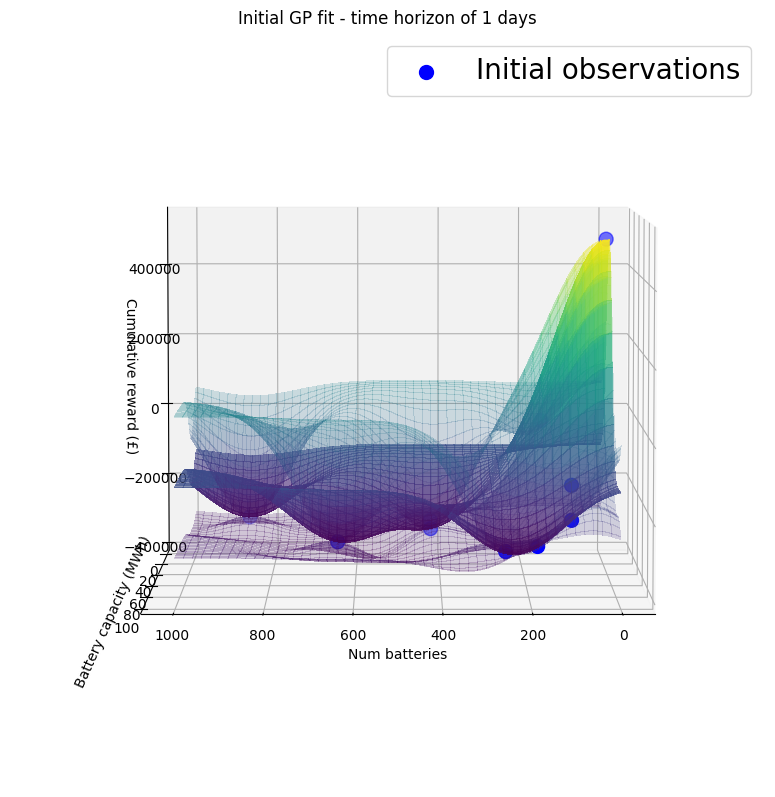

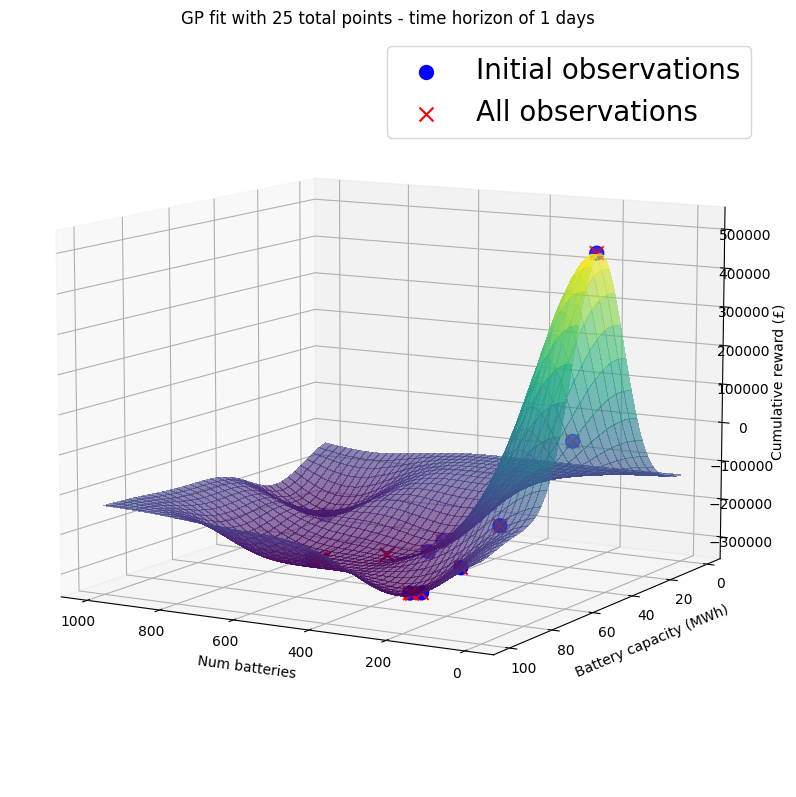

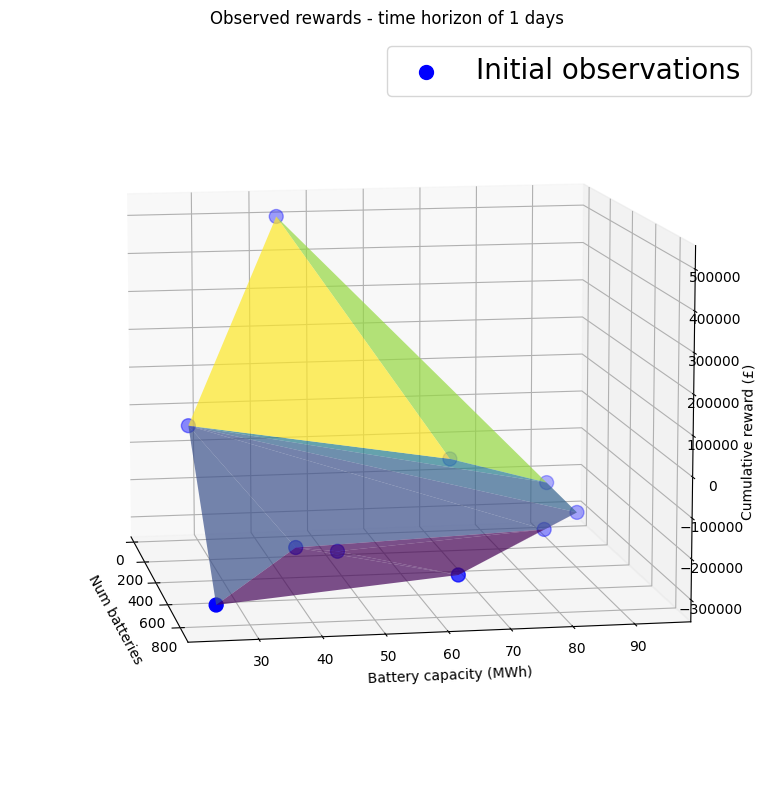

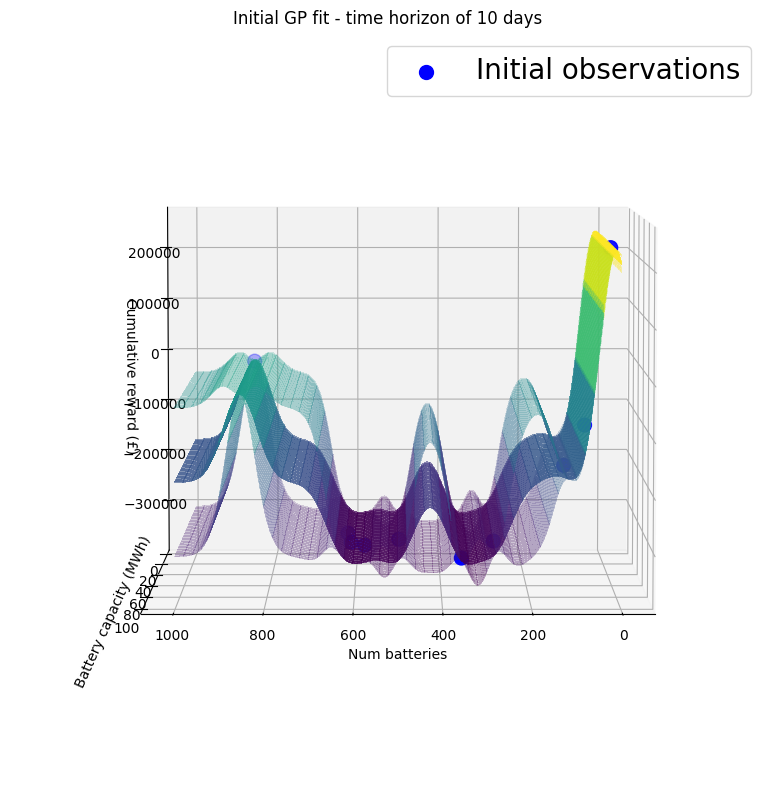

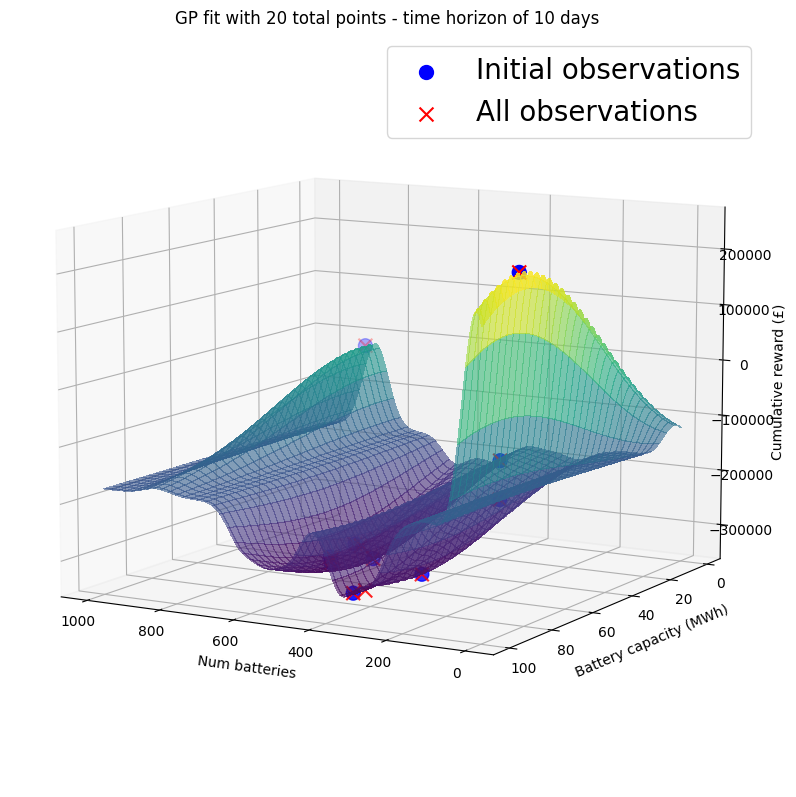

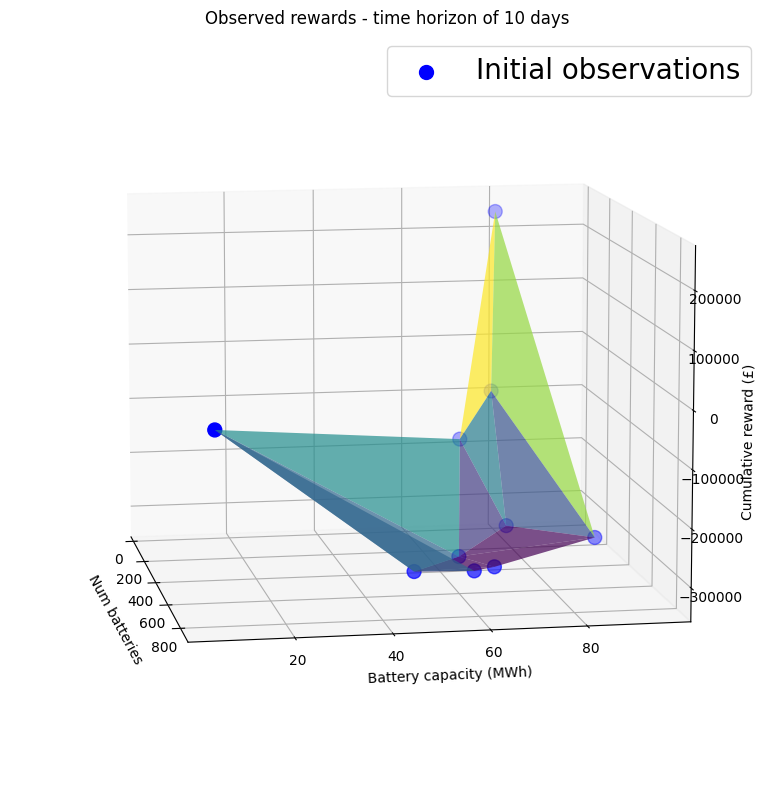

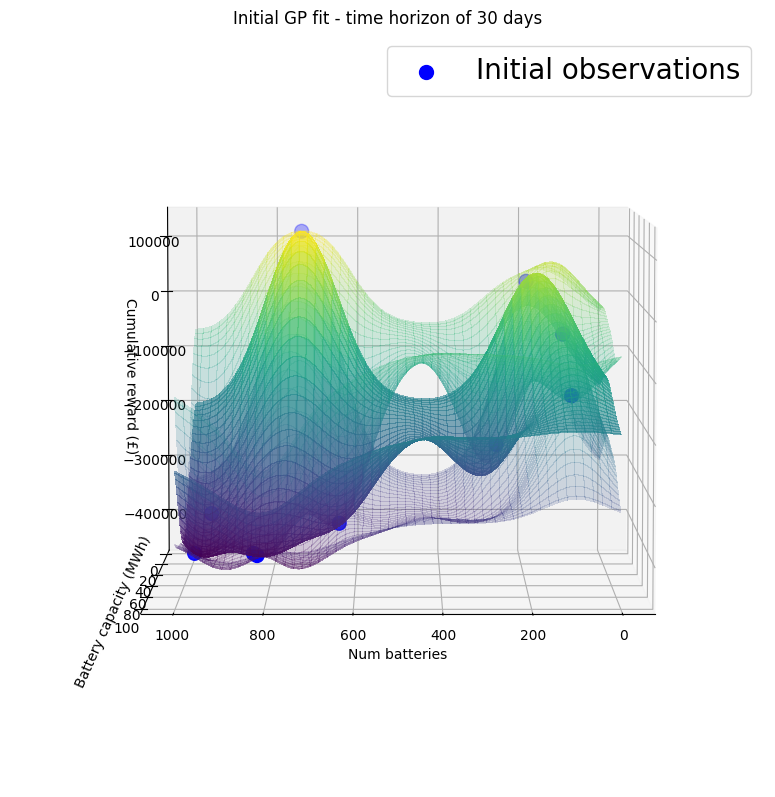

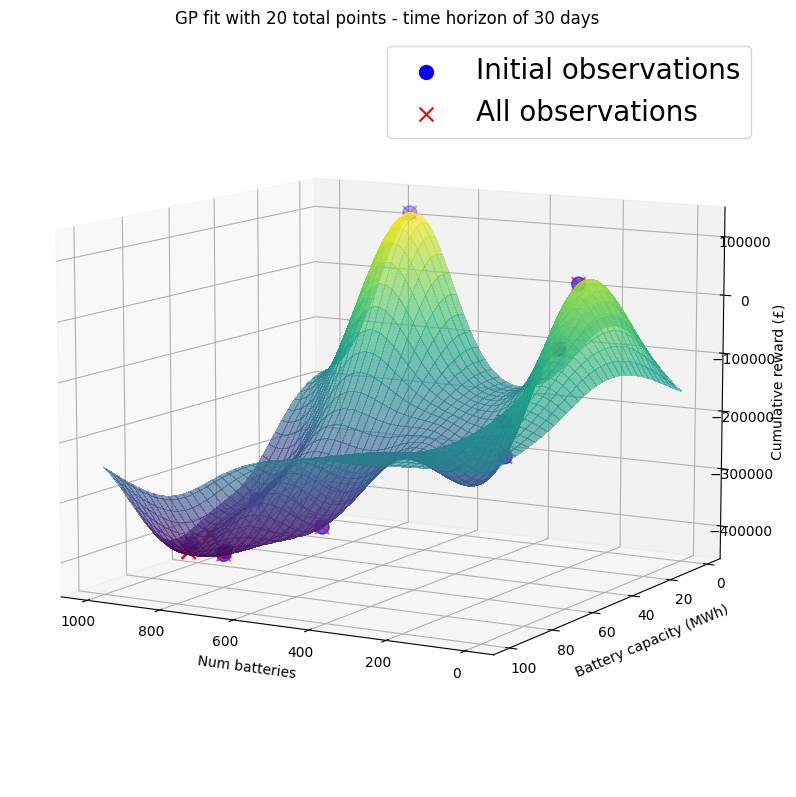

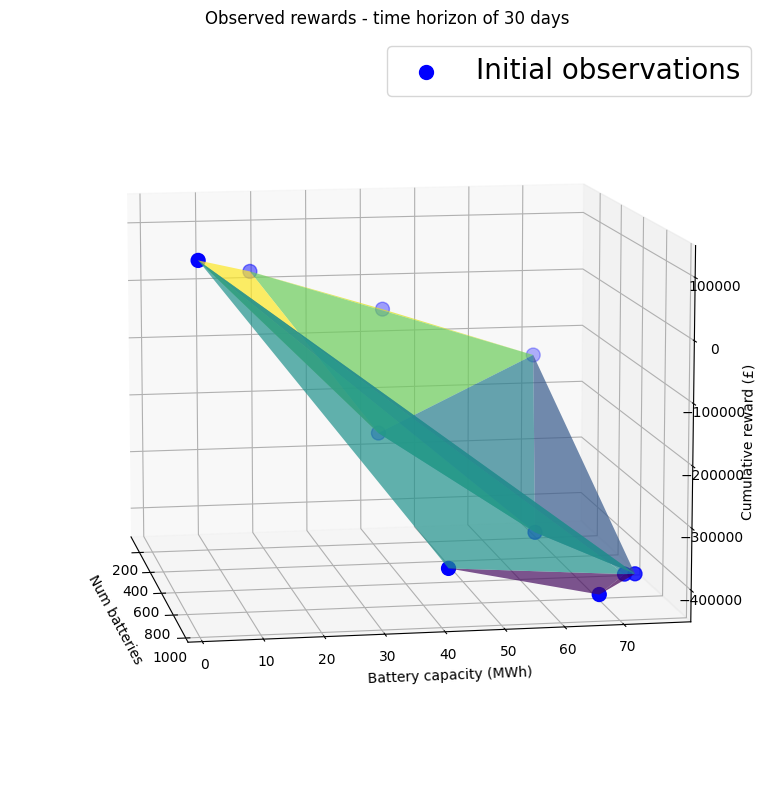

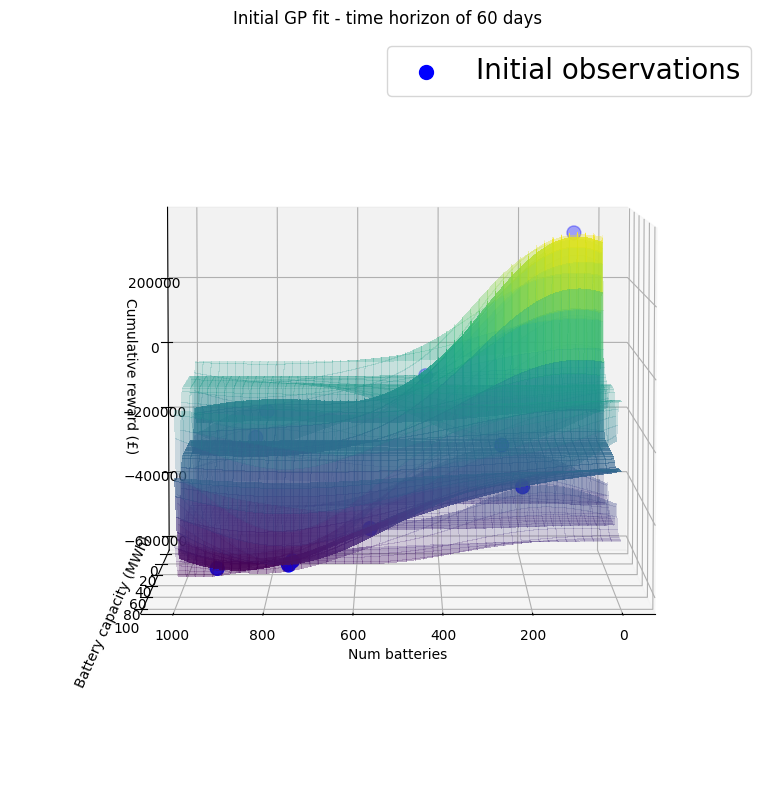

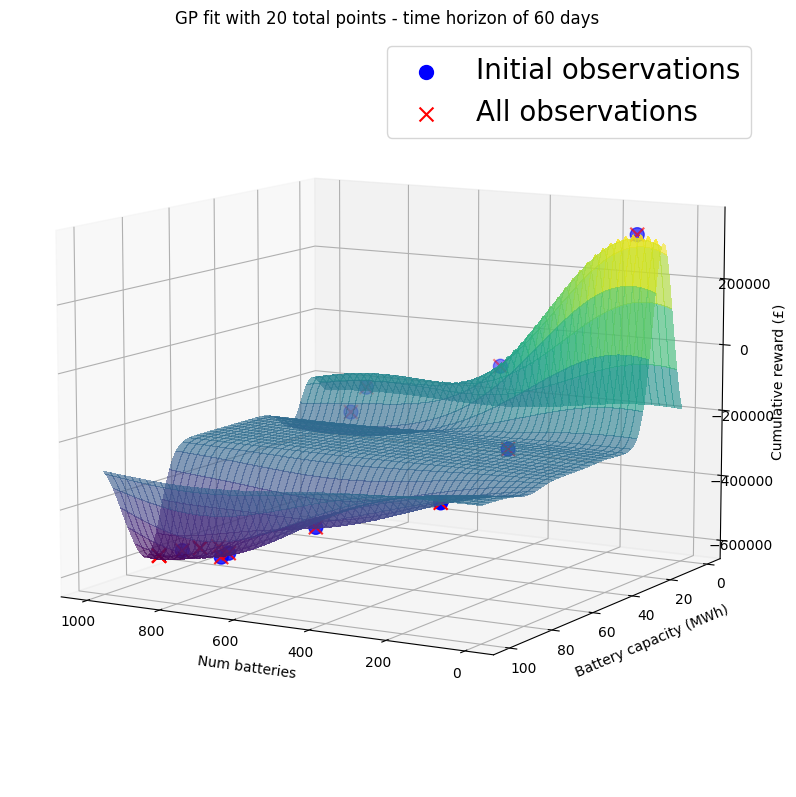

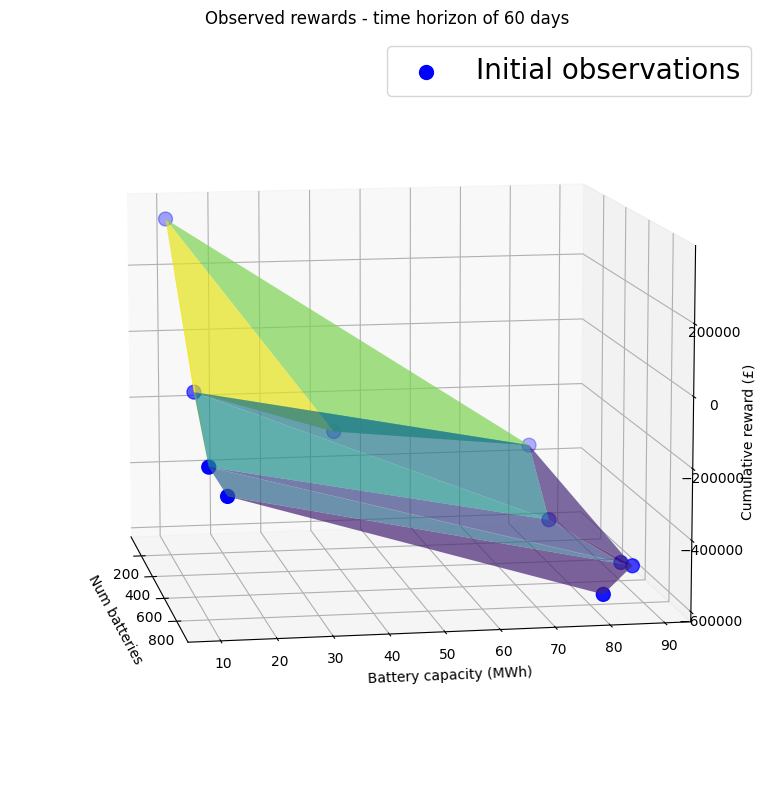

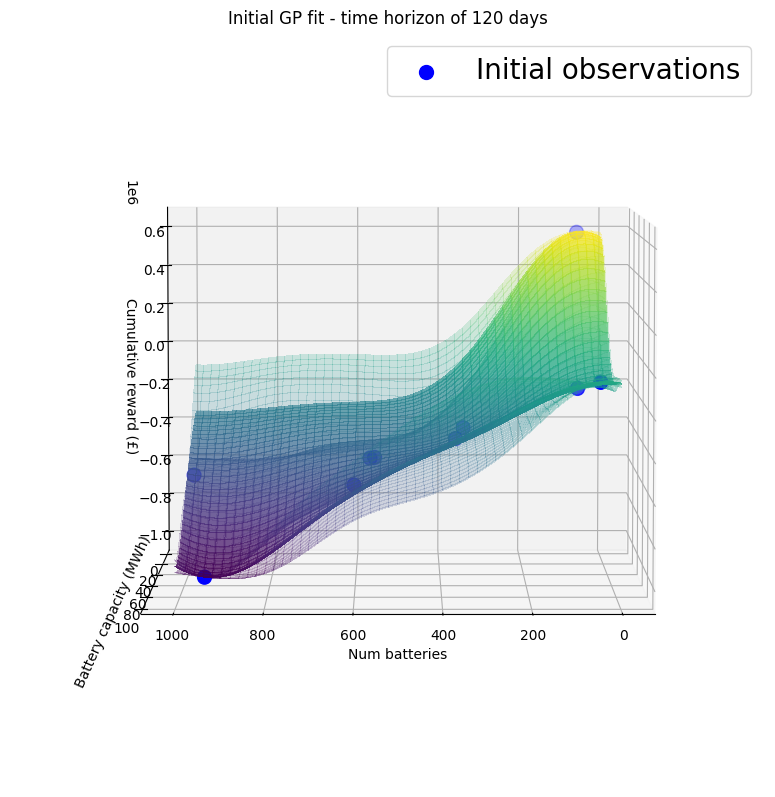

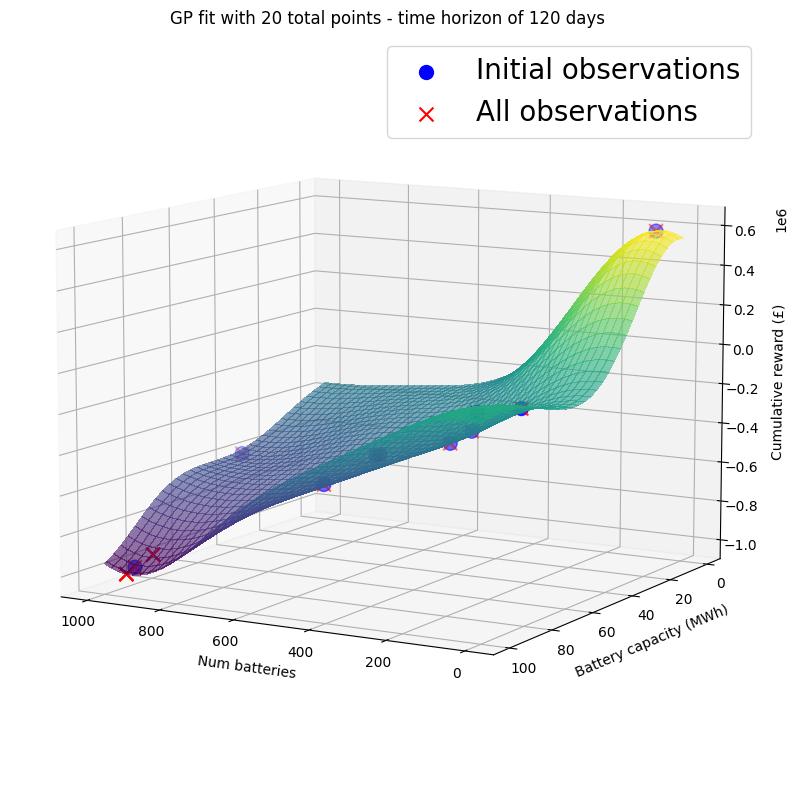

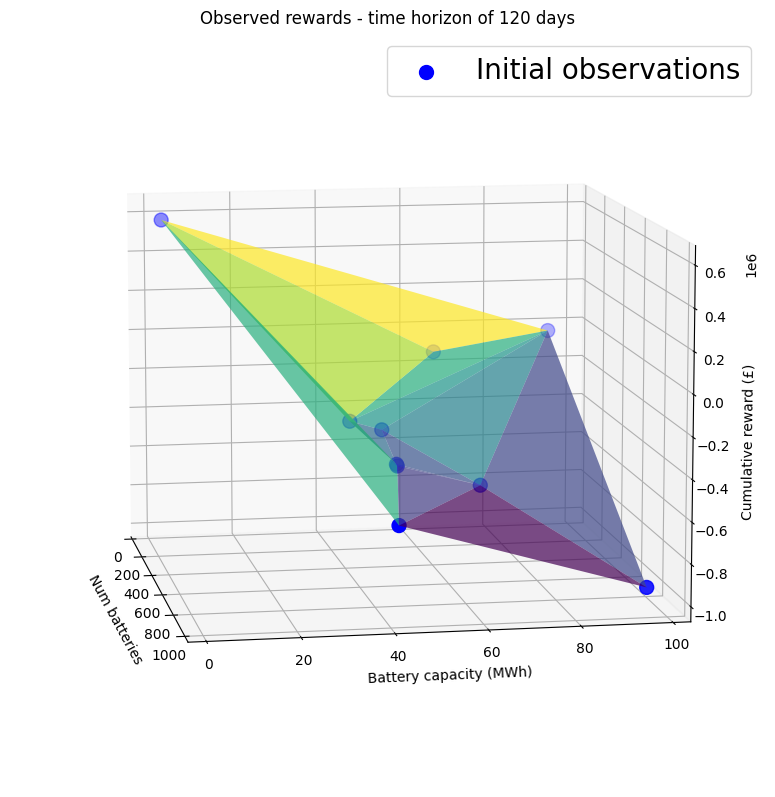

In [69]:
for i in range(0, 1):
    scenario_num = 0    
    scenario = possible_scenarios[scenario_num]

    all_results = {}
    print(20 * '=' + " using scenario [{}] ".format(scenario) + 20*'=')

    num_data_points = 10

    for num_days in [1, 10, 30, 60, 120]:

        if scenario_num == 1 and num_days in [1,10,30]:
            continue
        
        successful_sample = False
        num_tries = 0
        max_num_tries = 3

        while not successful_sample:

            print(f"CURRENT ATTEMPT #{num_tries}")
            try:
                config_res = {}

                timesteps_per_day = timesteps_per_week/7
                time_horizon_value = timesteps_per_day*num_days
                
                print('')
                print(20*'=' + " Simulating with time horizon of {} days ".format(num_days) + 20*'=')

                ### Specifying the parameter space here again for time horizon experiments

                # Specify time horizon here changing time_horizon_value above
                time_horizon = DiscreteParameter('time_horizon', [time_horizon_value])
                
                parameters = [num_batteries, max_battery_capacities, time_horizon] # no battery_penalty stuff in this experiment
                parameter_space = ParameterSpace(parameters)

                design = RandomDesign(parameter_space)

                # Get initial data points
                
                X = design.get_samples(num_data_points)
                start = time.time()
                Y = f_multiprocess(X)
                end = time.time()
                print("Getting {} initial simulation points took {} seconds".format(num_data_points, round(end - start, 0)))
                
                # Kernel Specification
                kr = GPy.kern.RBF(input_dim=X.shape[1]-1, ARD=True)  # exclude time dim
                kb = GPy.kern.Bias(input_dim=X.shape[1]-1)
                kernel = kr+kb

                # Some prior distributions for model parameters
                v_prior = GPy.priors.Gamma.from_EV(1000, 100.)
                l_prior = GPy.priors.Gamma.from_EV(100, 1000.)

                # Some prior distributions for model parameters
                gpy_model = GPy.models.GPRegression(X, Y, kernel, noise_var=1e-10)
                gpy_model.kern.rbf.variance.set_prior(v_prior)
                gpy_model.kern.rbf.lengthscale.set_prior(l_prior)
                gpy_model.Gaussian_noise.variance.constrain_fixed()

                # gpy_model.optimize()
                gpy_model.optimize_restarts(
                    num_restarts=10, robust=False, verbose=False, messages=False)

                # Logging GP fit
                # _ = gpy_model.plot()
                # print(gpy_model.kern.rbf.variance)
                display(gpy_model)
                print(gpy_model.kern.rbf.lengthscale)

                model_emukit = GPyModelWrapper(gpy_model)

                # Plot 3D decision boundary
                mesh_X, mesh_Y = np.mgrid[1:max_num_batteries+1:1,
                                        min_battery_capacity:max_battery_capacity+1:1]
                positions = np.vstack([mesh_X.ravel(), mesh_Y.ravel()]).T
                positions_with_time = np.append(positions, np.reshape(
                    np.array([time_horizon_value for _ in range(positions.shape[0])]), (-1, 1)), axis=1)

                # Get GP predictions across domain
                mu_plot, var_plot = model_emukit.predict(positions_with_time)
                
                # Make plot directory
                path = 'img/time_horizon/{}_scenario{}/'.format(num_days, scenario_num)
                if not(os.path.exists(path) and os.path.isdir(path)): 
                    os.mkdir(path)
                
                # Plot
                kwargs = {
                    'X': X,
                    'Y': Y,
                    'mesh_X': mesh_X,
                    'mesh_Y': mesh_Y,
                    'mu_plot': mu_plot,
                    'var_plot': var_plot,
                    'title': "Initial GP fit - time horizon of {} days".format(num_days),
                    'elev': 5,
                    'angle': 90,
                    'dpi': 100,
                    'save_fig_path': "img/time_horizon/{}_scenario{}/{}_sc{}_init".format(num_days, scenario_num, scenario_num, num_days)
                }
                fig, ax = plot_3d_boundary(**kwargs)

                # Choose acquisition function
                ei_acq = ExpectedImprovement(model_emukit)
                acq_func = ei_acq

                # Load core elements for Bayesian optimization
                optimizer = GradientAcquisitionOptimizer(space=parameter_space)

                # Create the Bayesian optimization object
                batch_size = 5
                bayesopt_loop = BayesianOptimizationLoop(model=model_emukit,
                                                        space=parameter_space,
                                                        acquisition=acq_func,
                                                        batch_size=batch_size)

                # Run the loop and extract the optimum;  we either complete 10 steps or converge
                max_iters = 10
                epsilon = 0.01
                stopping_condition = (FixedIterationsStoppingCondition(
                    i_max=max_iters) | ConvergenceStoppingCondition(eps=epsilon))

                start = time.time()
                bayesopt_loop.run_loop(f_multiprocess, stopping_condition)
                end = time.time()
                print("Successfully ran loop")
                successful_sample = True

                # Get acquired data
                new_X, new_Y = bayesopt_loop.loop_state.X, bayesopt_loop.loop_state.Y
                new_order = np.argsort(new_X[:, 0])
                new_X = new_X[new_order, :]
                new_Y = new_Y[new_order]
                total_num_points = new_Y.shape[0]
                num_eval_points = total_num_points-num_data_points
                print("Getting {} simulation points (batch size {}) took {} seconds".format(num_eval_points, batch_size, round(end - start, 0)))

                # Get results via BO call
                results = bayesopt_loop.get_results()
                print("minimum X: ", end='')
                print(results.minimum_location)
                print("minimum Y: ", end='')
                print(round(results.minimum_value, 0))

                # This assumes that first two columns of X were num_battery & max_battery_capacity
                best_total_inserted_capacity = results.minimum_location[0] * \
                    results.minimum_location[1]
                print("optimal total inserted capacity: {}".format(best_total_inserted_capacity))

                print("Number of (new) points evaluated: {} (batch size {})".format(
                    num_eval_points, batch_size))

                # Save model
                config_res['model'] = gpy_model.to_dict()
                config_res['best_reward'] = (results.minimum_location, results.minimum_value)
                config_res['num_data_points'] = num_data_points # number of initial data points
                config_res['num_eval_points'] = num_eval_points # num of BO points evaluated
                config_res['batch_size'] = batch_size
                config_res['max_iters'] = max_iters
                config_res['epsilon'] = epsilon
                config_res['eval_iters'] = num_eval_points//batch_size
                config_res['eval_time'] = round(end-start, 0)
                config_res['best_total_inserted_capacity'] = best_total_inserted_capacity

                # Plot 3D decision boundary
                mesh_X, mesh_Y = np.mgrid[1:max_num_batteries+1:1,
                                        min_battery_capacity:max_battery_capacity+1:1]
                positions = np.vstack([mesh_X.ravel(), mesh_Y.ravel()]).T
                positions_with_time = np.append(positions, np.reshape(
                    np.array([time_horizon_value for _ in range(positions.shape[0])]), (-1, 1)), axis=1)

                mu_plot, var_plot = model_emukit.predict(positions_with_time)
                kwargs = {
                    'X': X,
                    'Y': Y,
                    'plot_new': True,
                    'new_X': new_X,
                    'new_Y': new_Y,
                    'mesh_X': mesh_X,
                    'mesh_Y': mesh_Y,
                    'mu_plot': mu_plot,
                    'var_plot': var_plot,
                    'title': "GP fit with {} total points - time horizon of {} days".format(total_num_points, num_days),
                    'plot_ci': False,
                    'elev': 10,
                    'angle': 120,
                    'save_fig_path': "img/time_horizon/{}_scenario{}/{}_sc{}_sim".format(num_days, scenario_num, scenario_num, num_days)
                }
                fig, ax = plot_3d_boundary(**kwargs)

                # Plot rewards
                kwargs = {
                    'X': X,
                    'Y': Y,
                    'new_X': new_X,
                    'new_Y': new_Y,
                    'elev': 10,
                    'angle': 120,
                    'title': "Observed rewards - time horizon of {} days".format(num_days),
                    'save_fig_path': "img/time_horizon/{}_scenario{}/{}_sc{}_obs".format(num_days, scenario_num, num_days, scenario_num)
                }
                fig, ax = plot_3d_observed_rewards(**kwargs)

                # Save results
                config_res['mu_plot'] = mu_plot
                config_res['var_plot'] = var_plot
                all_results[num_days] = config_res
            except:
                num_tries += 1


    # LOGGING & SAVING
    joblib.dump(all_results, 'results/time_horizon_sc{}.pkl'.format(scenario_num))
    print(parameter_space.parameter_names)
    for days in all_results.keys():
        min_X, min_Y = all_results[days]['best_reward']
        print(min_X, end='\t\t')
        print("{:>4}".format(min_X[2]/48), end='\t')
        print("{:^8}".format(round(min_Y)), end='\t')
        print("{} (total inserted capacity)".format(
            all_results[days]['best_total_inserted_capacity']))


In [70]:
%ls results/

time_horizon.pkl        time_horizon_sc1.pkl    time_horizon_sc4.pkl
time_horizon_0_100.pkl  time_horizon_sc2.pkl
time_horizon_sc0.pkl    time_horizon_sc3.pkl


In [ ]:
joblib.load('results/time_horizon.pkl')


In [57]:

# config_res = joblib.load('results/time_horizon.pkl')

['results/time_horizon_sc2.pkl']

Print the lowest reward (best configuration) and the associated total capacity inserted for each time horizon value

In [71]:
print(parameter_space.parameter_names)
for days in all_results.keys():
    min_X, min_Y = all_results[days]['best_reward']
    print(min_X, end='\t\t')
    print("{:>4}".format(min_X[2]/48), end='\t')
    print("{:^8}".format(round(min_Y)), end='\t')
    print("{} (total inserted capacity)".format(
        all_results[days]['best_total_inserted_capacity']))


['num_batteries', 'max_battery_capacity', 'time_horizon']
[640.  66.  48.]		 1.0	-295759 	42240.0 (total inserted capacity)
[577.  68. 480.]		10.0	-317182 	39236.0 (total inserted capacity)
[ 948.   72. 1440.]		30.0	-418467 	68256.0 (total inserted capacity)
[ 973.   81. 2880.]		60.0	-582516 	78813.0 (total inserted capacity)
[ 939.  100. 5760.]		120.0	-982632 	93900.0 (total inserted capacity)


In [58]:
print(parameter_space.parameter_names)
for days in all_results.keys():
    min_X, min_Y = all_results[days]['best_reward']
    print(min_X, end='\t\t')
    print("{:>4}".format(min_X[2]/48), end='\t')
    print("{:^8}".format(round(min_Y)),end='\t')
    print("{} (total inserted capacity)".format(all_results[days]['best_total_inserted_capacity']))


['num_batteries', 'max_battery_capacity', 'time_horizon']
[856.  96.  48.]		 1.0	-298203 	82176.0 (total inserted capacity)
[935.  96. 480.]		10.0	-348097 	89760.0 (total inserted capacity)
[ 986.   85. 1440.]		30.0	-447018 	83810.0 (total inserted capacity)
[ 986.   87. 2880.]		60.0	-608101 	85782.0 (total inserted capacity)
[ 585.   92. 5760.]		120.0	-688346 	53820.0 (total inserted capacity)


## The old stuff

Get rewards of initial set of points

In [53]:
Y = f_multiprocess(X)

100%|██████████| 10/10 [00:32<00:00,  3.26s/it]


Specify kernels, priors, fit GP to initial set, log the GP, plot initial fit

INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


GP_regression.,value,constraints,priors
sum.rbf.variance,712882.1850997368,+ve,"Ga(1e+04, 10)"
sum.rbf.lengthscale,"(2,)",+ve,"Ga(10, 0.1)"
sum.bias.variance,444436621.65634894,+ve,
Gaussian_noise.variance,1e-10,+ve fixed,


  index  |  GP_regression.sum.rbf.lengthscale  |  constraints  |    priors   
  [0]    |                        35.45359253  |      +ve      |  Ga(10, 0.1)
  [1]    |                      1828.71489343  |      +ve      |  Ga(10, 0.1)


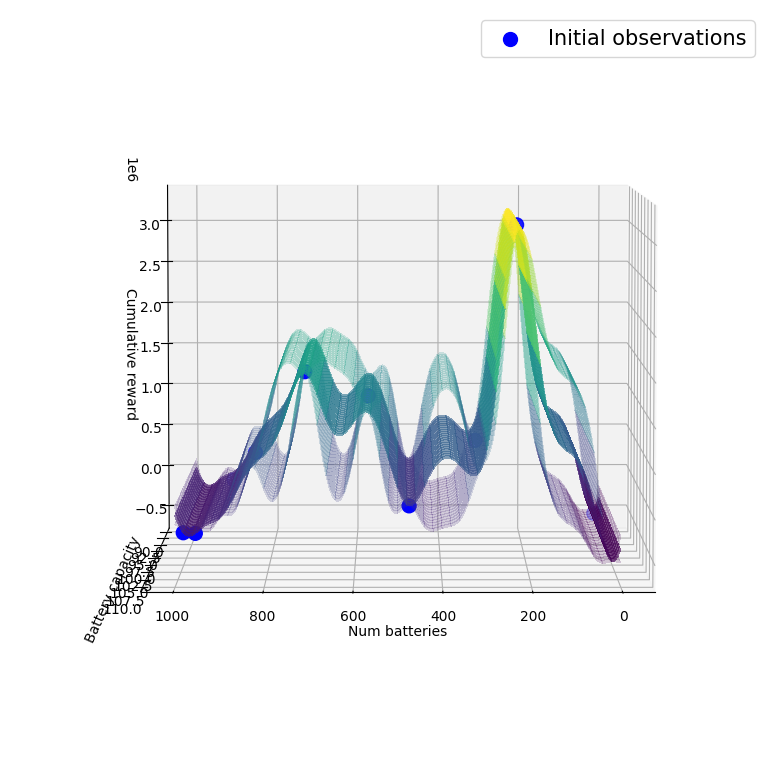

In [97]:
# Kernel Specification
kr = GPy.kern.RBF(input_dim=X.shape[1]-1, ARD=True) # exclude time dim
kb = GPy.kern.Bias(input_dim=X.shape[1]-1)
kernel = kr+kb

# Some prior distributions for model parameters
v_prior = GPy.priors.Gamma.from_EV(1000, 100.)
l_prior = GPy.priors.Gamma.from_EV(100, 1000.)

# Some prior distributions for model parameters
gpy_model = GPy.models.GPRegression(X, Y, kernel, noise_var=1e-10)
gpy_model.kern.rbf.variance.set_prior(v_prior)
gpy_model.kern.rbf.lengthscale.set_prior(l_prior)
gpy_model.Gaussian_noise.variance.constrain_fixed()

# gpy_model.optimize()
gpy_model.optimize_restarts(num_restarts=10, robust=False, verbose=False, messages=False)

# Logging GP fit
# _ = gpy_model.plot()
# print(gpy_model.kern.rbf.variance)
display(gpy_model)
print(gpy_model.kern.rbf.lengthscale)

model_emukit = GPyModelWrapper(gpy_model)

# Plot 3D decision boundary
mesh_X, mesh_Y = np.mgrid[1:max_num_batteries+1:1,
                          min_battery_capacity:max_battery_capacity+1:1]
positions = np.vstack([mesh_X.ravel(), mesh_Y.ravel()]).T
positions_with_time = np.append(positions, np.reshape(
    np.array([time_horizon_value for _ in range(positions.shape[0])]), (-1, 1)), axis=1)

mu_plot, var_plot = model_emukit.predict(positions_with_time)
kwargs = {
    'X': X,
    'Y': Y,
    'mesh_X': mesh_X,
    'mesh_Y': mesh_Y,
    'mu_plot': mu_plot,
    'var_plot': var_plot,
    'elev': 5,
    'angle': 90
}
fig, ax = plot_3d_boundary(**kwargs)

Specify acq function, run BO, print best reward found

In [98]:
# Choose acquisition function
ei_acq = ExpectedImprovement(model_emukit)
acq_func = ei_acq

# Load core elements for Bayesian optimization
optimizer = GradientAcquisitionOptimizer(space=parameter_space)

# Create the Bayesian optimization object
batch_size = 3
bayesopt_loop = BayesianOptimizationLoop(model=model_emukit,
                                         space=parameter_space,
                                         acquisition=acq_func,
                                         batch_size=batch_size)

# Run the loop and extract the optimum;  we either complete 10 steps or converge
max_iters = 3
epsilon = 0.01
stopping_condition = (FixedIterationsStoppingCondition(
    i_max=max_iters) | ConvergenceStoppingCondition(eps=epsilon))

bayesopt_loop.run_loop(f_multiprocess, stopping_condition)
print("Successfully ran loop")
successful_sample = True

# Get acquired data
new_X, new_Y = bayesopt_loop.loop_state.X, bayesopt_loop.loop_state.Y
new_order = np.argsort(new_X[:, 0])
new_X = new_X[new_order, :]
new_Y = new_Y[new_order]
total_num_points = new_Y.shape[0]

results = bayesopt_loop.get_results()
print("minimum X: ")
print(results.minimum_location)
print("minimum Y: ")
print(results.minimum_value)

print("Number of (new) points evaluated: {} (batch size {})".format(
    total_num_points-num_data_points, batch_size))

print(results.best_found_value_per_iteration)

INFO:emukit.bayesian_optimization.loops.bayesian_optimization_loop:Batch size is 3, using LocalPenalizationPointCalculator
INFO:emukit.core.loop.outer_loop:Starting outer loop
INFO:emukit.core.loop.outer_loop:Iteration 0
INFO:emukit.core.loop.model_updaters:Updating parameters of the model
INFO:emukit.core.optimization.gradient_acquisition_optimizer:Starting gradient-based optimization of acquisition function <class 'emukit.core.acquisition.acquisition.Sum'>
INFO:emukit.core.optimization.gradient_acquisition_optimizer:Starting gradient-based optimization of acquisition function <class 'emukit.core.acquisition.acquisition.Sum'>
INFO:emukit.core.optimization.gradient_acquisition_optimizer:Starting gradient-based optimization of acquisition function <class 'emukit.core.acquisition.acquisition.Sum'>
INFO:emukit.core.loop.user_function:Evaluating user function for 3 point(s)
100%|██████████| 3/3 [00:18<00:00,  6.26s/it]
INFO:emukit.core.loop.outer_loop:Iteration 1
INFO:emukit.core.loop.mode

Successfully ran loop
minimum X: 
[295.  99. 336.]
minimum Y: 
-575640.1985841452
Number of (new) points evaluated: 9 (batch size 3)
[-500337.35321147 -500337.35321147 -500337.35321147 -500337.35321147
 -500337.35321147 -500337.35321147 -500337.35321147 -500337.35321147
 -500337.35321147 -500337.35321147 -553368.68333334 -553368.68333334
 -553368.68333334 -553368.68333334 -553368.68333334 -553368.68333334
 -575640.19858415 -575640.19858415 -575640.19858415]


Plot the resulting 3D decision boundary

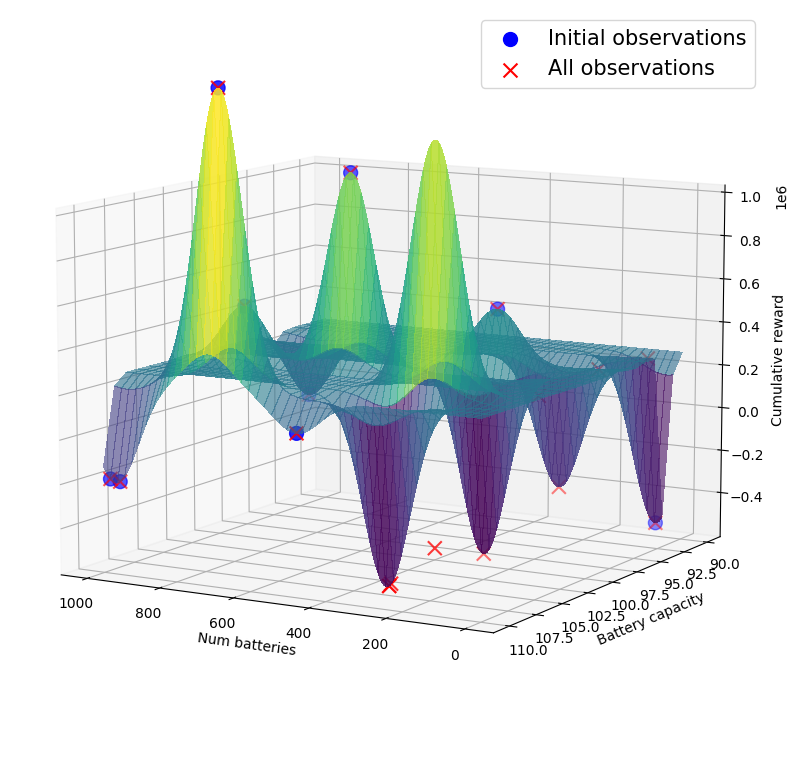

In [107]:
# Plot 3D decision boundary
mesh_X, mesh_Y = np.mgrid[1:max_num_batteries+1:1,
                          min_battery_capacity:max_battery_capacity+1:1]
positions = np.vstack([mesh_X.ravel(), mesh_Y.ravel()]).T
positions_with_time = np.append(positions, np.reshape(
    np.array([time_horizon_value for _ in range(positions.shape[0])]), (-1, 1)), axis=1)


mu_plot, var_plot = model_emukit.predict(positions_with_time)
kwargs = {
    'X': X,
    'Y': Y,
    'plot_new': True,
    'new_X': new_X,
    'new_Y': new_Y,
    'mesh_X': mesh_X,
    'mesh_Y': mesh_Y,
    'mu_plot': mu_plot,
    'var_plot': var_plot,
    'plot_ci': False,
    'elev': 10,
    'angle': 120,
    'z_lims': (min(new_Y), 1e6)
}
fig, ax = plot_3d_boundary(**kwargs)


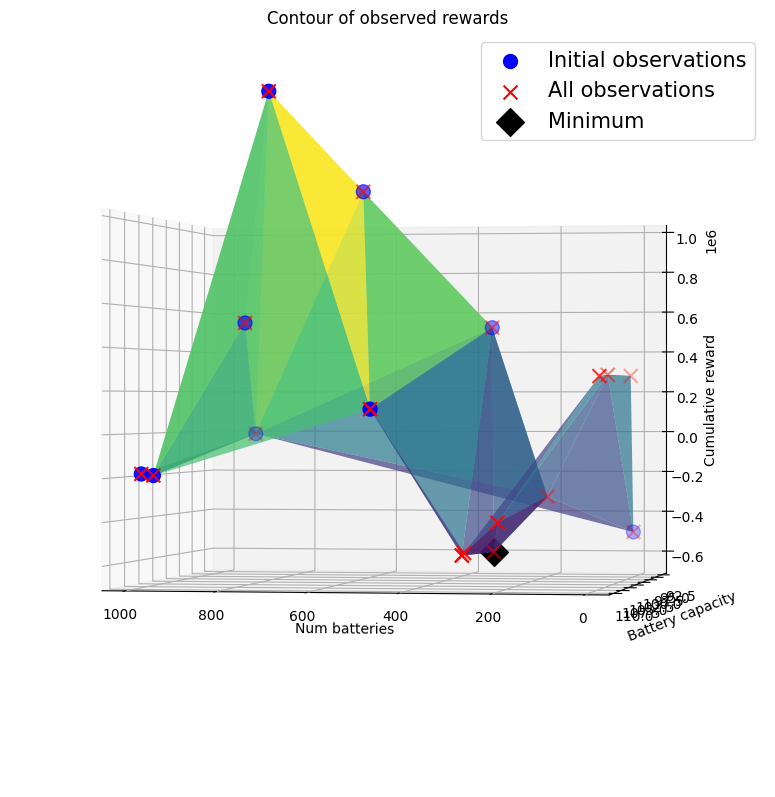

In [120]:
kwargs = {
    'X': X,
    'Y': Y,
    'new_X': new_X,
    'new_Y': new_Y,
    'elev': 0,
    'angle': 100,
    'z_lims': (min(new_Y)-1e5, 1e6)
}
fig, ax = plot_3d_observed_rewards(**kwargs)
plt.show()

In [ ]:
results = bayesopt_loop.get_results()
results.minimum_location, results.minimum_value # , results.best_found_value_per_iteration

(array([795.,  98.]), -49066704.85591315)

Plot 3D decision boundary

In [ ]:
# Plot 3D decision boundary
mesh_X, mesh_Y = np.mgrid[1:max_num_batteries+1:1,
                          min_battery_capacity:max_battery_capacity+1:1]
positions = np.vstack([mesh_X.ravel(), mesh_Y.ravel()]).T

mu_plot, var_plot = model_emukit.predict(positions)

fig = plt.figure(figsize=(15, 15))
ax = fig.gca(projection='3d')
surf = ax.plot_surface(mesh_X, mesh_Y, mu_plot.reshape(
    (1000, 21)), cmap='viridis', linewidth=0, antialiased=False, alpha=0.60)

# surf_var = ax.plot_surface(mesh_X, mesh_Y, (mu_plot-var_plot).reshape((1000, 21)), cmap='viridis', linewidth=0, antialiased=False, alpha=0.10)
# surf_var = ax.plot_surface(me sh_X, mesh_Y, (mu_plot+var_plot).reshape((1000, 21)), cmap='viridis', linewidth=0, antialiased=False, alpha=0.20)

# fig.colorbar(surf)

ax.scatter(X[:, 0].flatten(), X[:, 1].flatten(), Y.flatten(),
           s=100, marker="o", color="b", label="Initial observations")
ax.scatter(new_X[:, 0].flatten(), new_X[:, 1].flatten(),
           new_Y.flatten(), marker="x", color="r", label="All observations", s=100)

ax.grid(True)
ax.set_xlabel("Num batteries")
ax.set_ylabel("Battery capacity")
ax.set_zlabel("Cumulative reward")
plt.title("GP mean with {}".format(gpy_model.kern.name))
plt.legend(loc='upper right', prop={'size': 15})

# for angle in range(0, 360, 40):
ax.view_init(elev=10., azim=80)

plt.show()


Plot actual observation surface

Minimum value found:
[328.  90.] -620552.6527396751


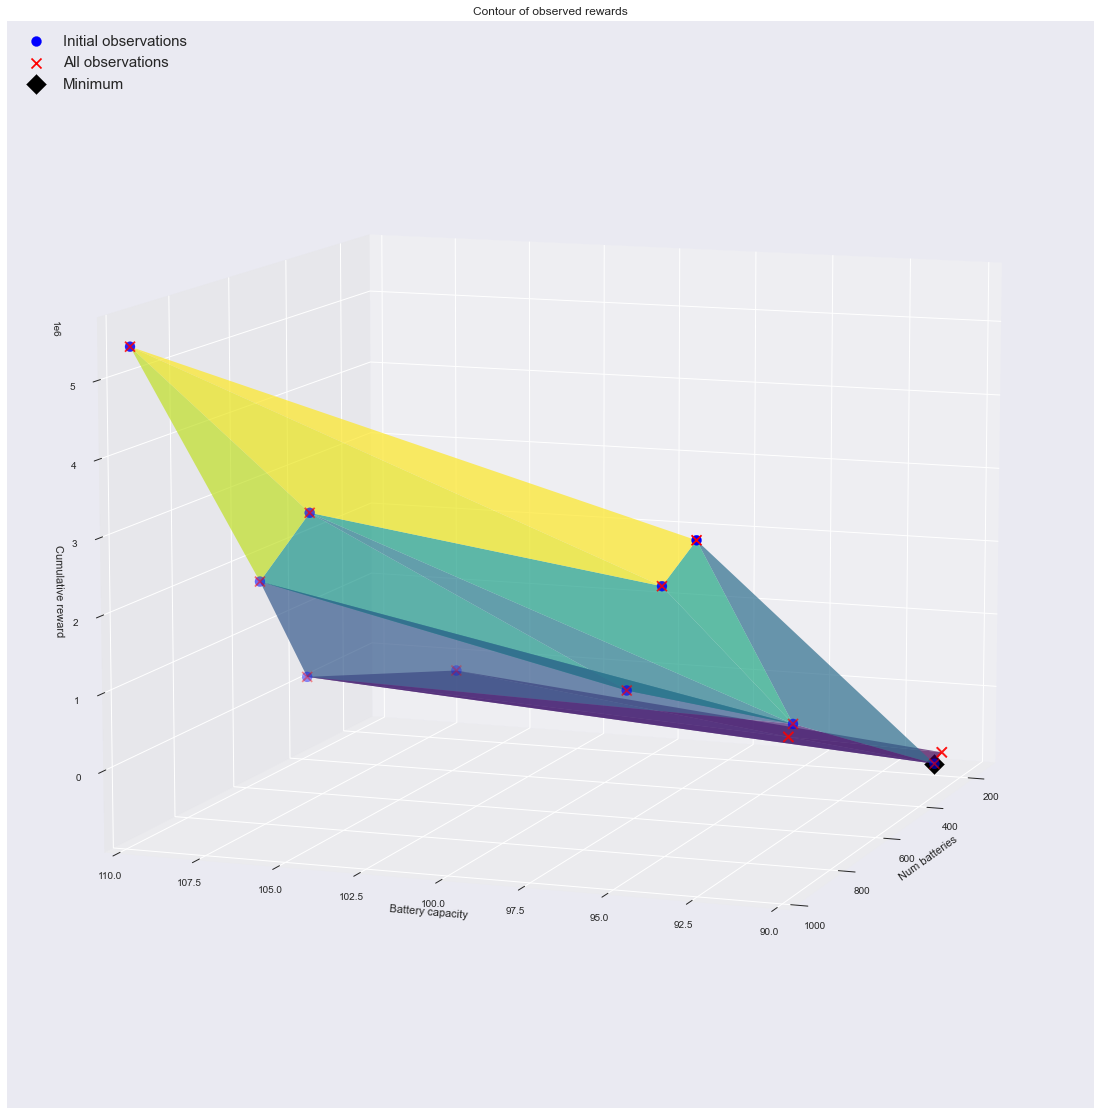

In [ ]:
fig = plt.figure(figsize=(20, 20))
ax = plt.axes(projection='3d')

new_X, new_Y = bayesopt_loop.loop_state.X, bayesopt_loop.loop_state.Y
new_order = np.argsort(new_X[:, 0])
new_X = new_X[new_order, :]
new_Y = new_Y[new_order]

x_plot = np.reshape(
    np.array([i for i in range(0, max_num_batteries)]), (-1, 1))
X_plot = np.append(x_plot, np.reshape(
    [100 for i in range(max_num_batteries)], (-1, 1)), axis=1)
mu_plot, var_plot = model_emukit.predict(X_plot)

im = ax.plot_trisurf(new_X[:, 0].flatten(), new_X[:, 1].flatten(
), new_Y.flatten(), cmap=cm.get_cmap('viridis'), alpha=0.70)
# fig.colorbar(im)

ax.scatter(X[:, 0].flatten(), X[:, 1].flatten(), Y.flatten(),
           s=100, marker="o", color="b", label="Initial observations")
ax.scatter(new_X[:, 0].flatten(), new_X[:, 1].flatten(),
           new_Y.flatten(), marker="x", color="r", label="All observations", s=100)

min_X = new_X[np.argmin(new_Y)]
min_Y = np.min(new_Y)
ax.scatter(min_X[0], min_X[1], min_Y, c='black',
           marker='D', label="Minimum", s=200)

LEGEND_SIZE = 15
ax.legend(loc=2, prop={'size': LEGEND_SIZE})
ax.set_xlabel("Num batteries")
ax.set_ylabel("Battery capacity")
ax.set_zlabel("Cumulative reward")

ax.view_init(elev=10., azim=20)
ax.set_ylim(110, 90)
ax.grid(True)
plt.title("Contour of observed rewards")
print("Minimum value found:")
print(min_X, min_Y)
# plt.savefig("img/rq_sim.png")

plt.show()
